In [ ]:
!pip install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import os
import zipfile
import random
import math
import string

import open_clip
from PIL import Image
from datasets import load_dataset
from transformers import AutoTokenizer, BartForConditionalGeneration
from huggingface_hub import hf_hub_download

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim import AdamW

from tqdm.auto import tqdm

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import matplotlib.pyplot as plt

In [ ]:
drive.mount('/content/drive')
DRIVE_FOLDER = "/content/drive/MyDrive/Colab Notebooks/WOA7015_Advanced_ML/AA"
WEIGHT_FOLDER = DRIVE_FOLDER + "/Weights"

if not os.path.exists(WEIGHT_FOLDER):
    os.makedirs(WEIGHT_FOLDER)

BASE_NAME = "med_vqa_model_1.pth"

Mounted at /content/drive


# Dataset

In [ ]:
REPO_ID = "BoKelvin/SLAKE"
EXTRACT_PATH = "./slake_extract"

print("Downloading images from Hugging Face...")
try:
    img_zip_path = hf_hub_download(repo_id=REPO_ID, filename="imgs.zip", repo_type="dataset")
except Exception as e:
    print(f"Download failed: {e}")

if not os.path.exists(EXTRACT_PATH):
    os.makedirs(EXTRACT_PATH)
    print("Extracting images...")
    with zipfile.ZipFile(img_zip_path, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
    print("Extraction complete.")
else:
    print("Images already extracted.")

if os.path.exists(os.path.join(EXTRACT_PATH, 'imgs')):
    IMG_DIR = os.path.join(EXTRACT_PATH, 'imgs')
    print(f"Found subfolder 'imgs'. Setting IMG_DIR to: {IMG_DIR}")
else:
    IMG_DIR = EXTRACT_PATH
    print(f"No subfolder found. Setting IMG_DIR to: {IMG_DIR}")

test_path = os.path.join(IMG_DIR, 'xmlab0', 'source.jpg')
if os.path.exists(test_path):
    print("SUCCESS: Verified image path structure.")
else:
    print(f"WARNING: Could not find test image at {test_path}.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


imgs.zip:   0%|          | 0.00/212M [00:00<?, ?B/s]

Extracting images...
Extraction complete.
Found subfolder 'imgs'. Setting IMG_DIR to: ./slake_extract/imgs
SUCCESS: Verified image path structure.


In [ ]:
BIOMEDCLIP_ID = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
BIOBART_ID = 'GanjinZero/biobart-base'

print("Loading BioMedCLIP transforms...")
_, _, preprocess_img = open_clip.create_model_and_transforms(BIOMEDCLIP_ID)

print("Loading BioBART tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(BIOBART_ID)

Loading BioMedCLIP transforms...


open_clip_config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

open_clip_pytorch_model.bin:   0%|          | 0.00/784M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

Loading BioBART tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
MAX_LEN = 128

def transform_fn(batch):
    images = []
    keep_indices = []

    for i, img_name in enumerate(batch['img_name']):
        full_path = os.path.join(IMG_DIR, img_name)
        try:
            image = Image.open(full_path).convert("RGB")
            images.append(preprocess_img(image))
            keep_indices.append(i)
        except (FileNotFoundError, OSError):
            print(f"WARNING: Skipping missing image {img_name}")
            continue

    # Make sure these lists contain data for loaded images only
    valid_questions = [batch['question'][i] for i in keep_indices]
    valid_answers = [str(batch['answer'][i]) for i in keep_indices]
    valid_types = [batch['answer_type'][i] for i in keep_indices]

    text_inputs = tokenizer(
        valid_questions,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    target_inputs = tokenizer(
        valid_answers,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    )

    labels = target_inputs["input_ids"]
    # Ignore padding tokens (prevent prediction of text padding)
    labels[labels == tokenizer.pad_token_id] = -100

    return {
        "pixel_values": images,
        "input_ids": text_inputs["input_ids"],
        "attention_mask": text_inputs["attention_mask"],
        "labels": labels,
        "answer_text": valid_answers,
        "answer_type": valid_types
    }

In [ ]:
def custom_collate_fn(batch):
    pixel_values = torch.stack([item['pixel_values'] for item in batch])
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])

    # Batch can't contain strings, convert to list
    answer_texts = [item['answer_text'] for item in batch]
    answer_types = [item['answer_type'] for item in batch]

    return {
        'pixel_values': pixel_values,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'labels': labels,
        'answer_text': answer_texts,
        'answer_type': answer_types
    }

In [ ]:
print("Loading BoKelvin/SLAKE dataset...")
dataset = load_dataset(REPO_ID)
dataset = dataset.filter(lambda example: example['q_lang'] == 'en')
dataset = dataset.with_transform(transform_fn)

train_loader = DataLoader(dataset['train'], batch_size=16, shuffle=True, collate_fn=custom_collate_fn)
train_subset = Subset(dataset['train'], range(0, 200))
train_subset_loader = DataLoader(train_subset, batch_size=32, collate_fn=custom_collate_fn)
val_loader = DataLoader(dataset['validation'], batch_size=32, collate_fn=custom_collate_fn)
test_loader = DataLoader(dataset['test'], batch_size=32, collate_fn=custom_collate_fn)

print("Data Setup Complete.")

Loading BoKelvin/SLAKE dataset...


README.md:   0%|          | 0.00/568 [00:00<?, ?B/s]

train.json: 0.00B [00:00, ?B/s]

validation.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/9835 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2099 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2094 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9835 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2099 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2094 [00:00<?, ? examples/s]

Data Setup Complete.


# Model (BioMedCLIP + BioBART)

In [ ]:
class MedVQAModel(nn.Module):
    def __init__(self, device='cuda'):
        super().__init__()
        self.device = device

        # Vision Encoder (BioMedCLIP)
        clip_model, _, _ = open_clip.create_model_and_transforms(BIOMEDCLIP_ID)
        self.visual_encoder = clip_model.visual
        self.visual_encoder.requires_grad_(False)

        # Text Decoder (BioBART)
        self.decoder = BartForConditionalGeneration.from_pretrained(BIOBART_ID)
        self.decoder_dim = self.decoder.config.d_model # 768

        # Projector
        self.projector = nn.Sequential(
            nn.Linear(512, 2048),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(2048, self.decoder_dim)
        )

    # Helper to safely get scaled embeddings
    def get_text_embeddings(self, input_ids):
        # Access the shared embedding layer
        embed_tokens = self.decoder.model.shared(input_ids)

        # Scale embeddings if required by the config
        if getattr(self.decoder.config, "scale_embedding", False):
            embed_scale = math.sqrt(self.decoder.config.d_model)
            embed_tokens = embed_tokens * embed_scale

        return embed_tokens

    def prepare_multimodal_inputs(self, pixel_values, input_ids, attention_mask):
        # Encode image
        with torch.no_grad():
            image_embeds = self.visual_encoder(pixel_values) # (Batch, 512)

        # Project image
        image_embeds = self.projector(image_embeds).unsqueeze(1) # (Batch, 1, 768)

        # Encode text
        inputs_embeds = self.get_text_embeddings(input_ids)

        # Concatenate (image + text)
        combined_embeds = torch.cat([image_embeds, inputs_embeds], dim=1)

        # Extend mask (cater for concat)
        ones = torch.ones((input_ids.shape[0], 1), device=input_ids.device)
        combined_mask = torch.cat([ones, attention_mask], dim=1)

        return combined_embeds, combined_mask

    def forward(self, pixel_values, input_ids, attention_mask, labels=None):
        # Prepare inputs
        combined_embeds, combined_mask = self.prepare_multimodal_inputs(pixel_values, input_ids, attention_mask)

        # Decode
        outputs = self.decoder(
            inputs_embeds=combined_embeds,
            attention_mask=combined_mask,
            labels=labels
        )

        return outputs

    def generate(self, pixel_values, input_ids, attention_mask, max_new_tokens=20):
        with torch.no_grad():
            # Prepare inputs
            combined_embeds, combined_mask = self.prepare_multimodal_inputs(pixel_values, input_ids, attention_mask)

            # Generate
            return self.decoder.generate(
                inputs_embeds=combined_embeds,
                attention_mask=combined_mask,
                max_new_tokens=max_new_tokens,
                num_beams=3
            )

# Train and Evaluate

In [ ]:
# Lowercase, remove punctuation, clean whitespace
def normalize_text(text):
    text = text.lower()
    text = "".join([c for c in text if c not in string.punctuation])
    return " ".join(text.split())

def evaluate(model, loader, tokenizer, device, desc="Evaluating"):
    model.eval()

    correct_open = 0; total_open = 0
    correct_closed = 0; total_closed = 0
    total_loss = 0
    bleu_open = []; bleu_closed = []

    progress_bar = tqdm(loader, desc=desc, leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(pixel_values, input_ids, mask, labels=labels)
            total_loss += outputs.loss.item()

            generated_ids = model.generate(pixel_values, input_ids, mask, max_new_tokens=20)
            pred_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            ref_texts = batch['answer_text']
            types = batch['answer_type']

            for pred, ref, ans_type in zip(pred_texts, ref_texts, types):
                pred_clean = normalize_text(pred)
                ref_clean = normalize_text(ref)

                # Accuracy (checks for entire string match)
                is_correct = (pred_clean == ref_clean)

                # BLEU (1-gram)
                ref_tokens = ref_clean.split()
                pred_tokens = pred_clean.split()
                if not pred_tokens: pred_tokens = [""]
                score = sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=SmoothingFunction().method1)

                if ans_type == 'CLOSED':
                    total_closed += 1
                    bleu_closed.append(score)
                    if is_correct: correct_closed += 1
                else:
                    total_open += 1
                    bleu_open.append(score)
                    if is_correct: correct_open += 1

    avg_loss = total_loss / len(loader)

    acc_open = correct_open / total_open if total_open > 0 else 0
    acc_closed = correct_closed / total_closed if total_closed > 0 else 0

    total_samples = total_open + total_closed
    acc_overall = (correct_open + correct_closed) / total_samples if total_samples > 0 else 0

    avg_bleu_open = sum(bleu_open) / len(bleu_open) if bleu_open else 0
    avg_bleu_closed = sum(bleu_closed) / len(bleu_closed) if bleu_closed else 0
    all_bleu = bleu_open + bleu_closed
    avg_bleu_overall = sum(all_bleu) / len(all_bleu) if all_bleu else 0

    return {
        "loss": avg_loss,
        "acc_open": acc_open,
        "acc_closed": acc_closed,
        "acc_overall": acc_overall,
        "bleu_open": avg_bleu_open,
        "bleu_closed": avg_bleu_closed,
        "bleu_overall": avg_bleu_overall
    }

In [ ]:
def train_and_validate(model, train_loader, val_loader, train_subset_loader, optimizer, tokenizer, device, num_epochs):
    history = {
        "train_loss": [], "val_loss": [],
        "train_acc": [],  "val_acc": []
    }

    best_val_loss = float('inf')
    best_val_overall_acc = 0.0
    best_val_open_acc = 0.0

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

        for batch in progress_bar:
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(pixel_values, input_ids, mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = total_loss / len(train_loader)

        # Evaluate on validation set
        val_res = evaluate(model, val_loader, tokenizer, device, desc="Validating")

        # Evaluate on subset of train set (whole train set would be slow)
        train_res = evaluate(model, train_subset_loader, tokenizer, device, desc="Checking Train Acc")

        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_res['loss'])
        history["train_acc"].append(train_res['acc_overall'])
        history["val_acc"].append(val_res['acc_overall'])

        print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {val_res['loss']:.4f}")
        print(f"  Train Acc:  {train_res['acc_overall']:.4f} | Val Acc:  {val_res['acc_overall']:.4f}")
        print(f"  Val BLEU-1: {val_res['bleu_overall']:.4f}")

        if val_res['loss'] < best_val_loss:
            best_val_loss = val_res['loss']
            save_name = f"loss_best_{BASE_NAME}"
            full_path = os.path.join(WEIGHT_FOLDER, save_name)
            torch.save(model.state_dict(), full_path)
            print(f"  --> Saved to Drive: {save_name} (Val Loss: {best_val_loss:.4f})")

        if val_res['acc_overall'] > best_val_overall_acc:
            best_val_overall_acc = val_res['acc_overall']
            save_name = f"acc_overall_best_{BASE_NAME}"
            full_path = os.path.join(WEIGHT_FOLDER, save_name)
            torch.save(model.state_dict(), full_path)
            print(f"  --> Saved to Drive: {save_name} (Overall Acc: {best_val_overall_acc:.4f})")

        if val_res['acc_open'] > best_val_open_acc:
            best_val_open_acc = val_res['acc_open']
            save_name = f"acc_open_best_{BASE_NAME}"
            full_path = os.path.join(WEIGHT_FOLDER, save_name)
            torch.save(model.state_dict(), full_path)
            print(f"  --> Saved to Drive: {save_name} (Open Acc: {best_val_open_acc:.4f})")

    print("\nTraining Complete.")
    return history

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MedVQAModel(device).to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

history = train_and_validate(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    train_subset_loader=train_subset_loader,
    optimizer=optimizer,
    tokenizer=tokenizer,
    device=device,
    num_epochs=5,
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/279M [00:00<?, ?B/s]

Starting training for 5 epochs...


Epoch 1/5:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 1.0531 | Val Loss: 0.4297
  Train Acc:  0.5250 | Val Acc:  0.5489
  Val BLEU-1: 0.5743
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.4297)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.5489)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.5008)


Epoch 2/5:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.3958 | Val Loss: 0.2929
  Train Acc:  0.5700 | Val Acc:  0.6163
  Val BLEU-1: 0.6555
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.2929)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.6163)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.6117)


Epoch 3/5:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.2992 | Val Loss: 0.2473
  Train Acc:  0.7050 | Val Acc:  0.6790
  Val BLEU-1: 0.7131
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.2473)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.6790)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.6656)


Epoch 4/5:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.2501 | Val Loss: 0.2088
  Train Acc:  0.7250 | Val Acc:  0.7179
  Val BLEU-1: 0.7485
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.2088)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.7179)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.7100)


Epoch 5/5:   0%|          | 0/308 [00:00<?, ?it/s]

Validating:   0%|          | 0/33 [00:00<?, ?it/s]

Checking Train Acc:   0%|          | 0/7 [00:00<?, ?it/s]

  Train Loss: 0.2194 | Val Loss: 0.1792
  Train Acc:  0.7700 | Val Acc:  0.7388
  Val BLEU-1: 0.7635
  --> Saved to Drive: loss_best_med_vqa_model_1.pth (Val Loss: 0.1792)
  --> Saved to Drive: acc_overall_best_med_vqa_model_1.pth (Overall Acc: 0.7388)
  --> Saved to Drive: acc_open_best_med_vqa_model_1.pth (Open Acc: 0.7195)

Training Complete.


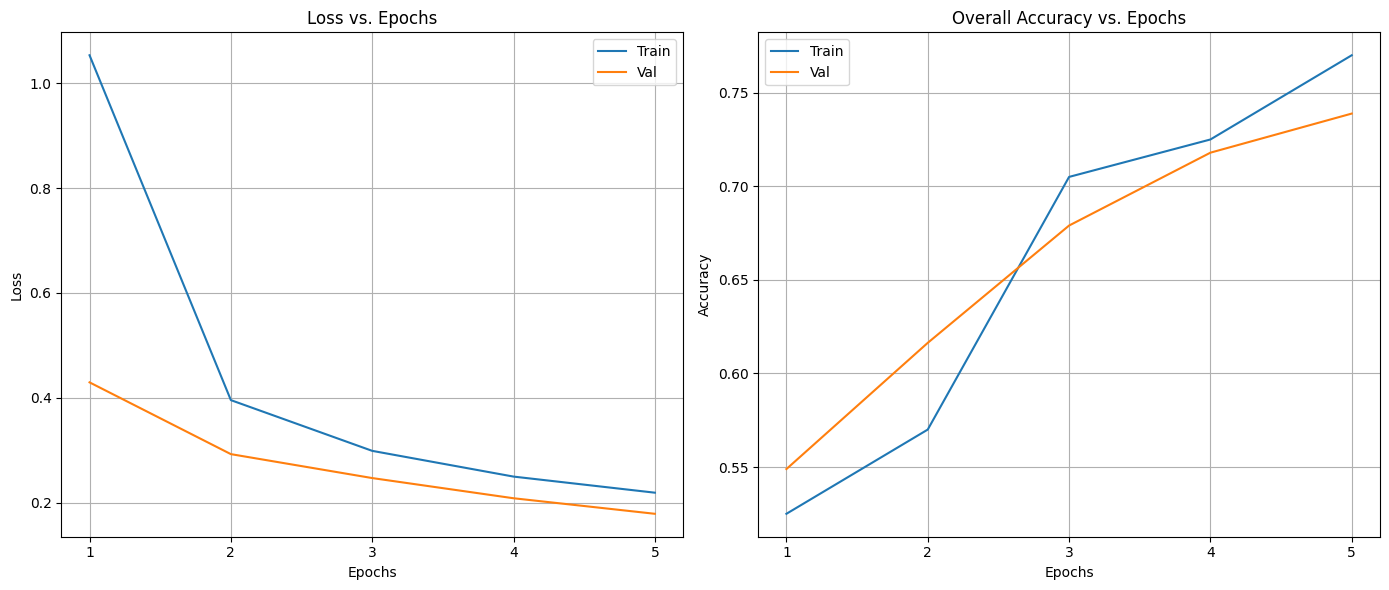

In [ ]:
def plot_curves(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.plot(epochs, history['val_loss'], label='Val')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs'); plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.legend(); plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.plot(epochs, history['val_acc'], label='Val')
    plt.title('Overall Accuracy vs. Epochs')
    plt.xlabel('Epochs'); plt.ylabel('Accuracy')
    plt.xticks(epochs)
    plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_curves(history)

# Evaluate with Test Set

In [ ]:
results = evaluate(model, test_loader, tokenizer, device)

print("\n" + "="*40)
print("FINAL EVALUATION RESULTS")
print("="*40)
print(f"OVERALL Accuracy: {results['acc_overall']:.4f}")
print(f"OVERALL BLEU-1:   {results['bleu_overall']:.4f}")
print("-" * 40)
print(f"CLOSED Questions:")
print(f"  Accuracy:       {results['acc_closed']:.4f}")
print(f"  BLEU-1:         {results['bleu_closed']:.4f}")
print("-" * 40)
print(f"OPEN Questions:")
print(f"  Accuracy:       {results['acc_open']:.4f}")
print(f"  BLEU-1:         {results['bleu_open']:.4f}")
print("="*40)

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]


FINAL EVALUATION RESULTS
OVERALL Accuracy: 0.7220
OVERALL BLEU-1:   0.7472
----------------------------------------
CLOSED Questions:
  Accuracy:       0.7692
  BLEU-1:         0.7692
----------------------------------------
OPEN Questions:
  Accuracy:       0.6915
  BLEU-1:         0.7329


# Visualize Prediction

In [ ]:
raw_test_dataset = load_dataset(REPO_ID, split="test")
raw_test_dataset = raw_test_dataset.filter(lambda x: x['q_lang'] == 'en')

def visualize_prediction(index):
    item = raw_test_dataset[index]
    img_name = item['img_name']
    question = item['question']
    answer = str(item['answer'])

    img_path = os.path.join(IMG_DIR, img_name)

    try:
        pil_image = Image.open(img_path).convert("RGB")
    except FileNotFoundError:
        print(f"Could not find image: {img_path}")
        return

    pixel_values = preprocess_img(pil_image).unsqueeze(0).to(device)

    text_inputs = tokenizer(
        question,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN
    ).to(device)

    input_ids = text_inputs["input_ids"]
    attention_mask = text_inputs["attention_mask"]

    # Run model
    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(pixel_values, input_ids, attention_mask)

    prediction = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    print(f"\n--- Sample {index} ---")
    print(f"Question:    {question}")
    print(f"Ground Truth: {answer}")
    print(f"Model Pred:   {prediction}")

    if prediction.strip().lower() == answer.strip().lower():
        print("Result:       ✅ MATCH")
    else:
        print("Result:       ❌ NOT MATCH")

    plt.figure(figsize=(8, 4))
    plt.imshow(pil_image)
    plt.axis('off')
    plt.title(f"Type: {item['answer_type']}\nQ: {question}", fontsize=12, loc='left')
    plt.show()

Filter:   0%|          | 0/2094 [00:00<?, ? examples/s]

In [ ]:
open_indices = [i for i, item in enumerate(raw_test_dataset) if item['answer_type'] == 'OPEN']
closed_indices = [i for i, item in enumerate(raw_test_dataset) if item['answer_type'] == 'CLOSED']

print(f"Found {len(open_indices)} OPEN questions and {len(closed_indices)} CLOSED questions.")

def show_samples_by_type(type_name, indices, num_to_show):
    print(f"\n{'='*40}")
    print(f"  VISUALIZING: {type_name} QUESTIONS")
    print(f"{'='*40}")

    # Pick random samples
    selected_indices = random.sample(indices, num_to_show)

    for idx in selected_indices:
        visualize_prediction(idx)

Found 645 OPEN questions and 416 CLOSED questions.



  VISUALIZING: CLOSED QUESTIONS

--- Sample 975 ---
Question:    Does the picture contain the organ which has the effect of excreting feces?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


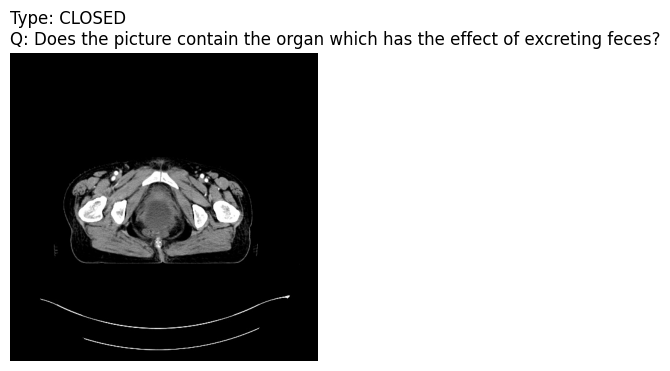


--- Sample 95 ---
Question:    Is the lung healthy?
Ground Truth: No
Model Pred:   No
Result:       ✅ MATCH


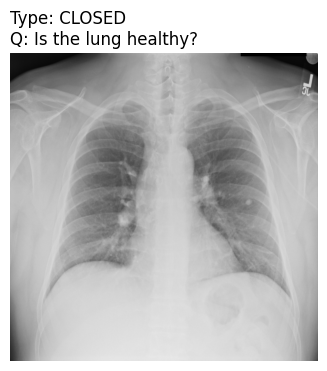


--- Sample 981 ---
Question:    Does the picture contain bladder?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


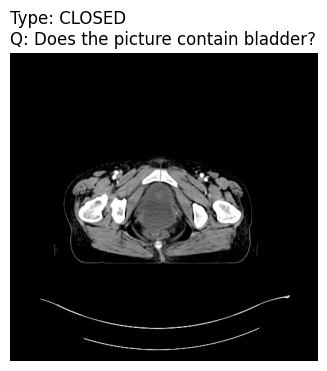


--- Sample 62 ---
Question:    Are there abnormalities in this image?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


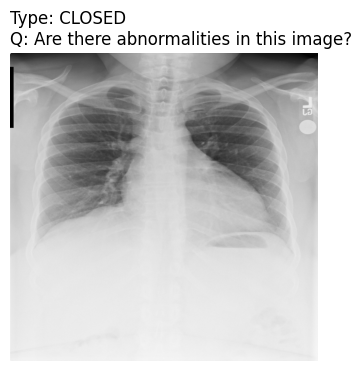


--- Sample 857 ---
Question:    Does the picture contain the organ which has the effect of discharging waste?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


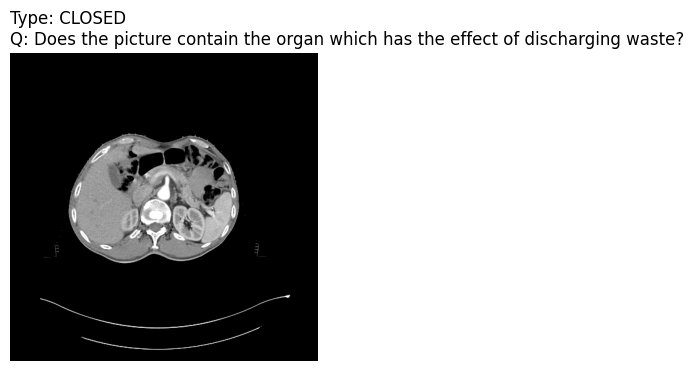


--- Sample 835 ---
Question:    Does the picture contain brian?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


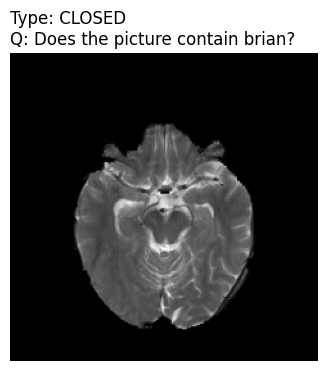


--- Sample 902 ---
Question:    Does the picture contain colon?
Ground Truth: No
Model Pred:   Yes
Result:       ❌ NOT MATCH


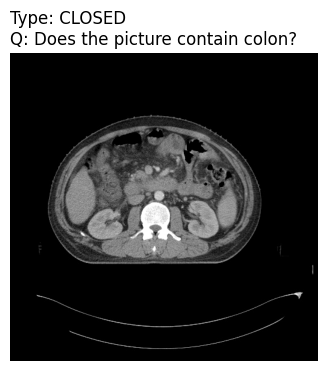


--- Sample 682 ---
Question:    Do the organs in the image exist in the head?
Ground Truth: Yes
Model Pred:   Yes
Result:       ✅ MATCH


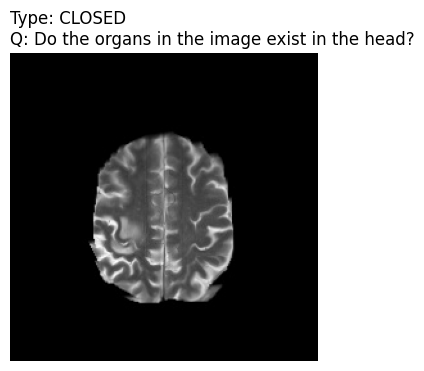


--- Sample 667 ---
Question:    Is this an MRI scan?
Ground Truth: No
Model Pred:   No
Result:       ✅ MATCH


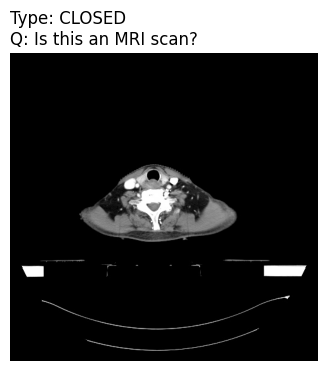


--- Sample 849 ---
Question:    Does the stomach appear in the image?
Ground Truth: No
Model Pred:   Yes
Result:       ❌ NOT MATCH


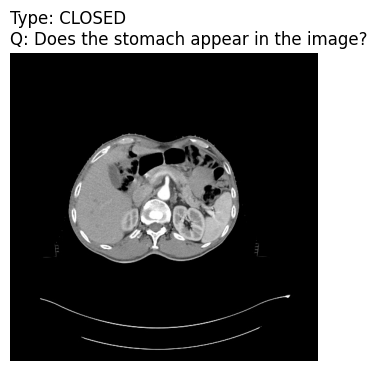

In [ ]:
show_samples_by_type("CLOSED", closed_indices, num_to_show=10)


  VISUALIZING: OPEN (Generative) QUESTIONS

--- Sample 110 ---
Question:    Where is/are the abnormality located?
Ground Truth: Right Lung, Lower Left
Model Pred:   Left Lung
Result:       ❌ NOT MATCH


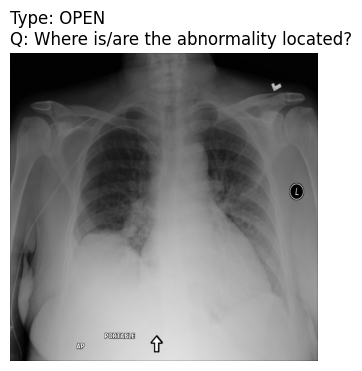


--- Sample 471 ---
Question:    Which organ system is imaged?
Ground Truth: Chest
Model Pred:   Chest
Result:       ✅ MATCH


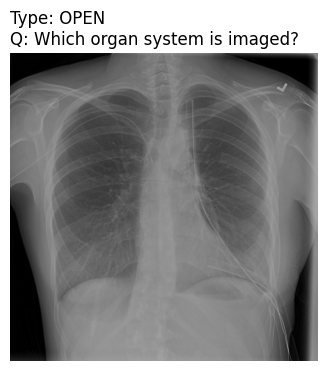


--- Sample 132 ---
Question:    What modality is used to take this image?
Ground Truth: X-Ray
Model Pred:   X2
Result:       ❌ NOT MATCH


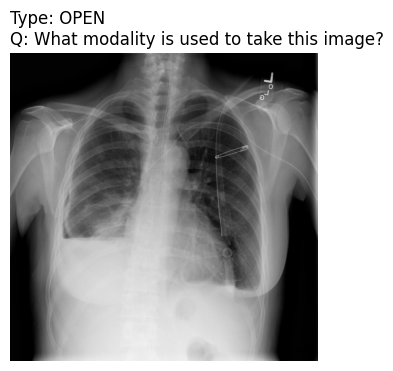


--- Sample 229 ---
Question:    What is the mr weighting in this image?
Ground Truth: T1
Model Pred:   T2
Result:       ❌ NOT MATCH


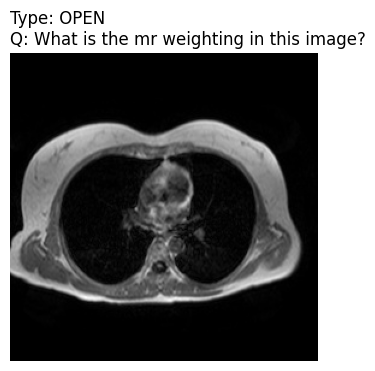


--- Sample 184 ---
Question:    What is the organ on the lower right corner of the body in this image?
Ground Truth: Spleen
Model Pred:   Left Kidney
Result:       ❌ NOT MATCH


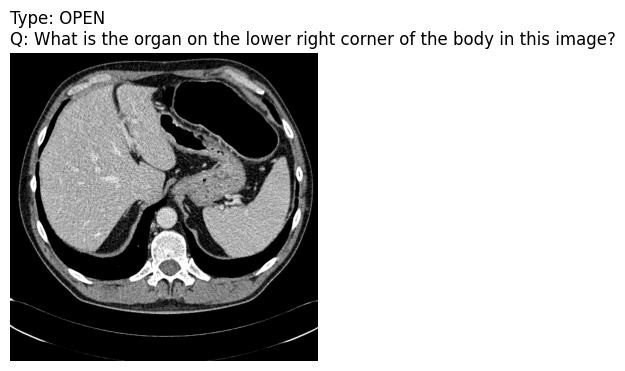


--- Sample 655 ---
Question:    What scanning plane does this image belong to?
Ground Truth: Transverse Plane
Model Pred:   Transverse Plane
Result:       ✅ MATCH


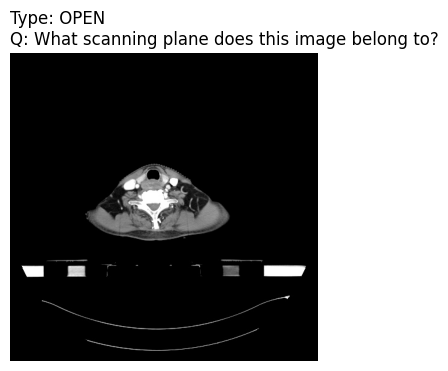


--- Sample 206 ---
Question:    What is the largest organ in the picture?
Ground Truth: Liver
Model Pred:   Liver
Result:       ✅ MATCH


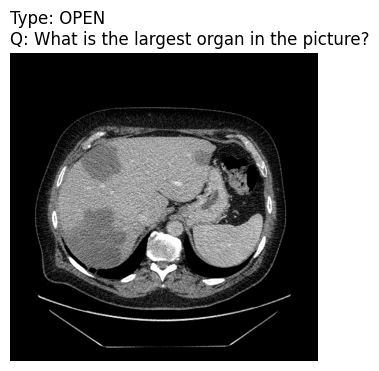


--- Sample 392 ---
Question:    Which part of the body does this image belong to?
Ground Truth: Chest
Model Pred:   Chest
Result:       ✅ MATCH


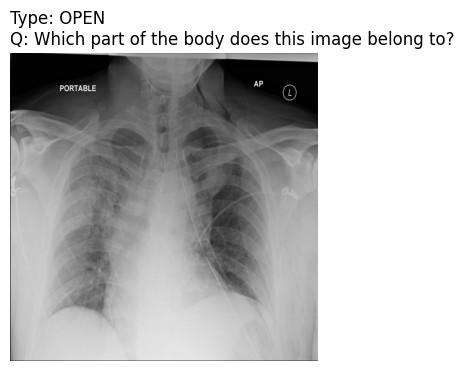


--- Sample 256 ---
Question:    What modality is used to take this image?
Ground Truth: CT
Model Pred:   CT
Result:       ✅ MATCH


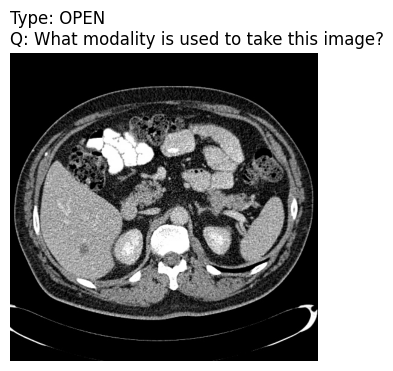


--- Sample 540 ---
Question:    How was this image taken?
Ground Truth: X-Ray
Model Pred:   X-Ray
Result:       ✅ MATCH


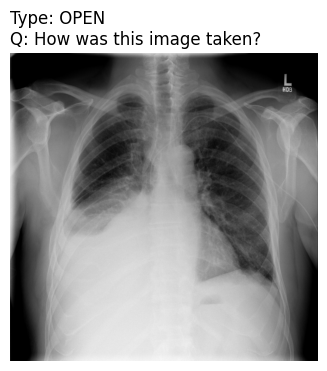

In [ ]:
show_samples_by_type("OPEN (Generative)", open_indices, num_to_show=10)